# Setup

In [1]:
import warnings

import numpy as np
from matplotlib import pyplot as plt

from compare_variance_residual.simulated.plotting import plot_experiment
from compare_variance_residual.simulated.simulation import run_experiment

warnings.simplefilter(action='ignore')
plt.style.use('ggplot')

In [2]:
from himalaya.backend import set_backend

backend = set_backend("cupy", on_error="warn")

# Set default values to be used in the tests

In [3]:
n_observations = 3

variables = dict(
    # dataset
    n_runs=10,
    d_list=[100, 100, 100],
    feature_space_weights=[1 / 3, 1 / 3, 1 / 3],
    n_targets=100,
    n_samples_train=1000,
    n_samples_test=100,
    noise_level=0.1,
    construction_method="stack",
    random_distribution="normal",

    # ridge regression
    alphas=np.logspace(-4, 4, 9),
    cv=10,

    # method parameters
    direct_variance_partitioning=False,
    ignore_negative_r2=False,
    use_ols=False,
)

# Varying distributions

In [4]:
variable_name = "sampling distribution"
random_distributions = [
    "normal",
    "uniform",
    "exponential",
    "gamma",
    "beta",
    "lognormal",
    "pareto"
]

In [5]:
predicted_variance, predicted_residual = run_experiment(random_distributions, variable_name, **variables)

[........................................] 100% | 238.74 sec | Varying sampling distribution | 


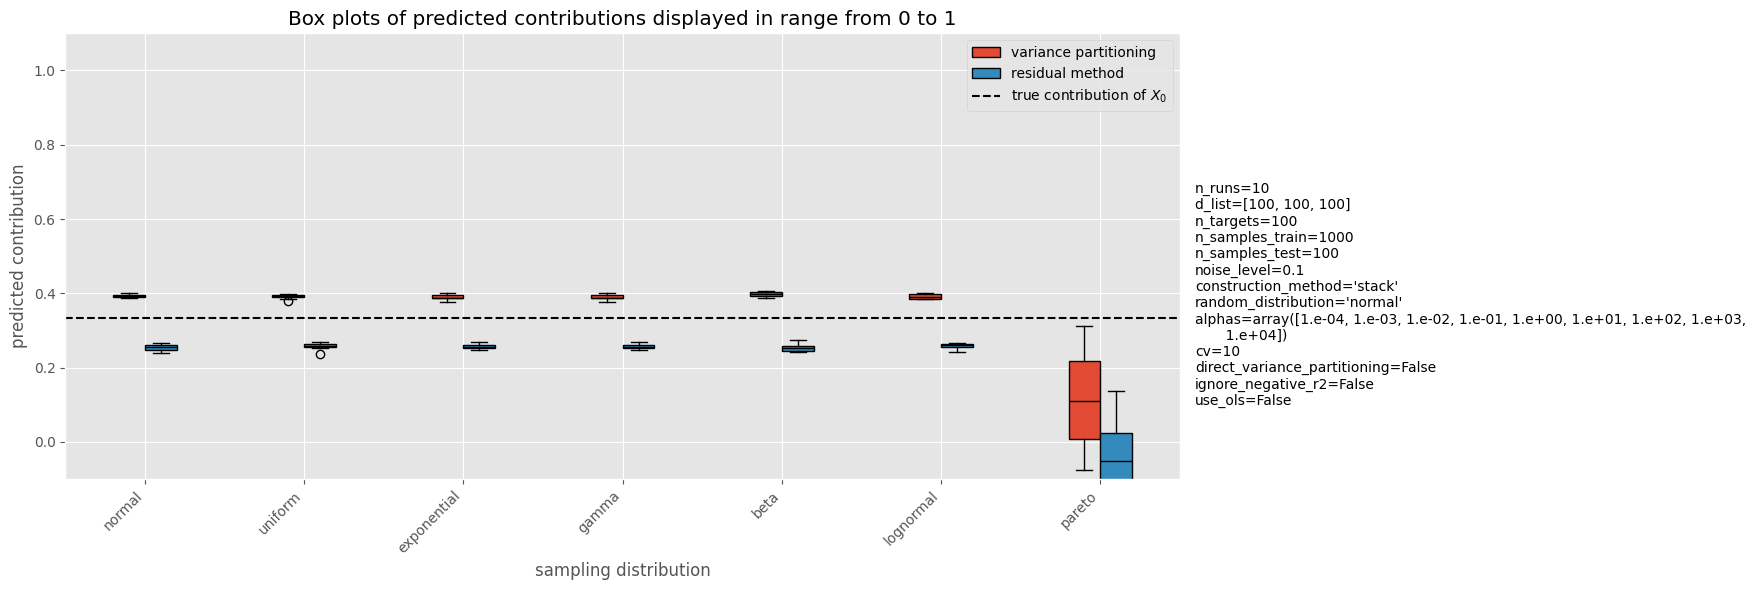

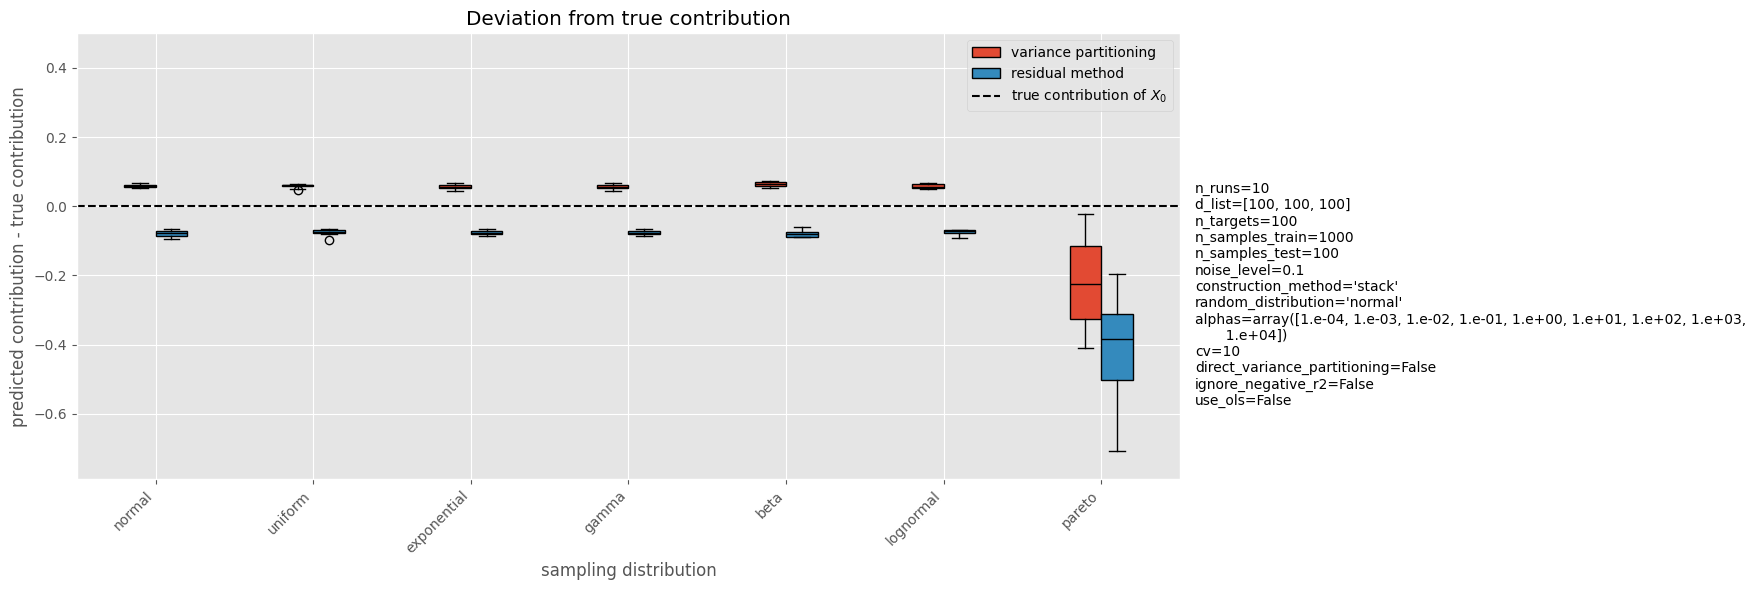

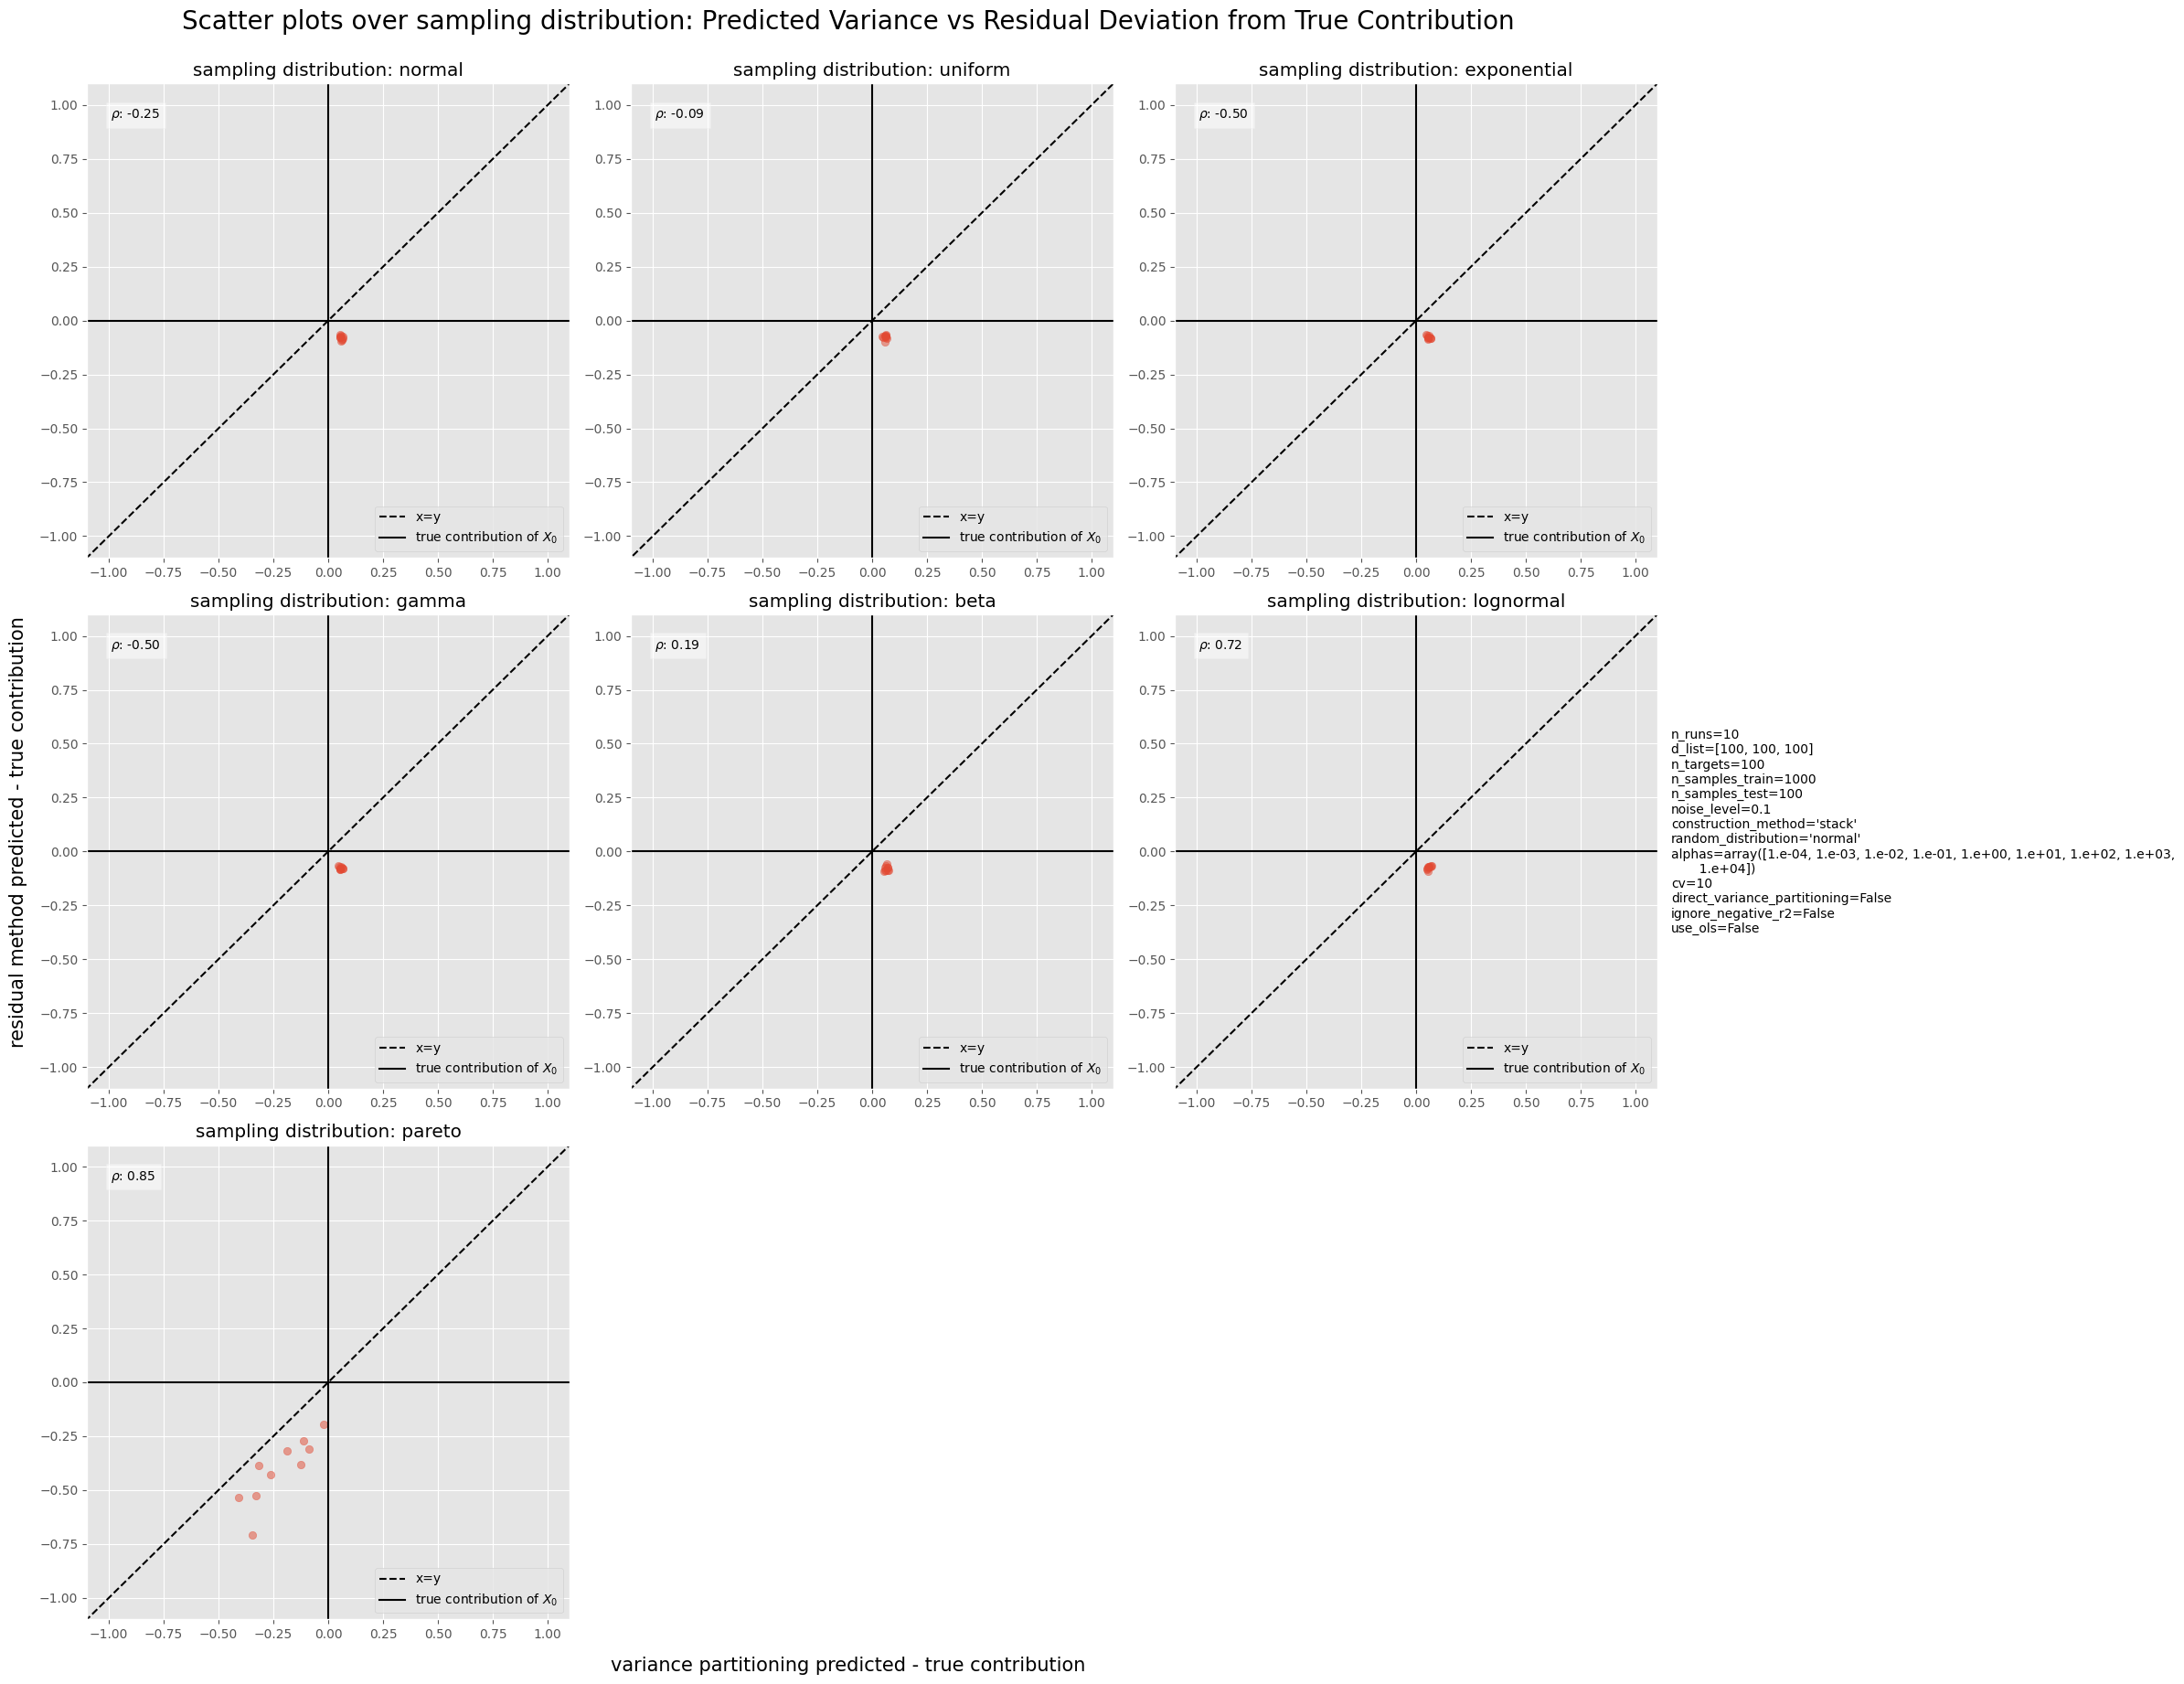

In [6]:
plot_experiment(random_distributions, variable_name, predicted_variance, predicted_residual, **variables)

# Test varying sample sizes

## varying train sample sizes

In [20]:
mag = np.log10(variables["n_samples_train"])
sample_sizes_training = np.logspace(mag - 1, mag + 1, n_observations)
variable_name = "sample size training"

In [21]:
predicted_variance, predicted_residual = run_experiment(sample_sizes_training, variable_name, **variables)

[........................................] 100% | 134.81 sec | Varying sample size training | 


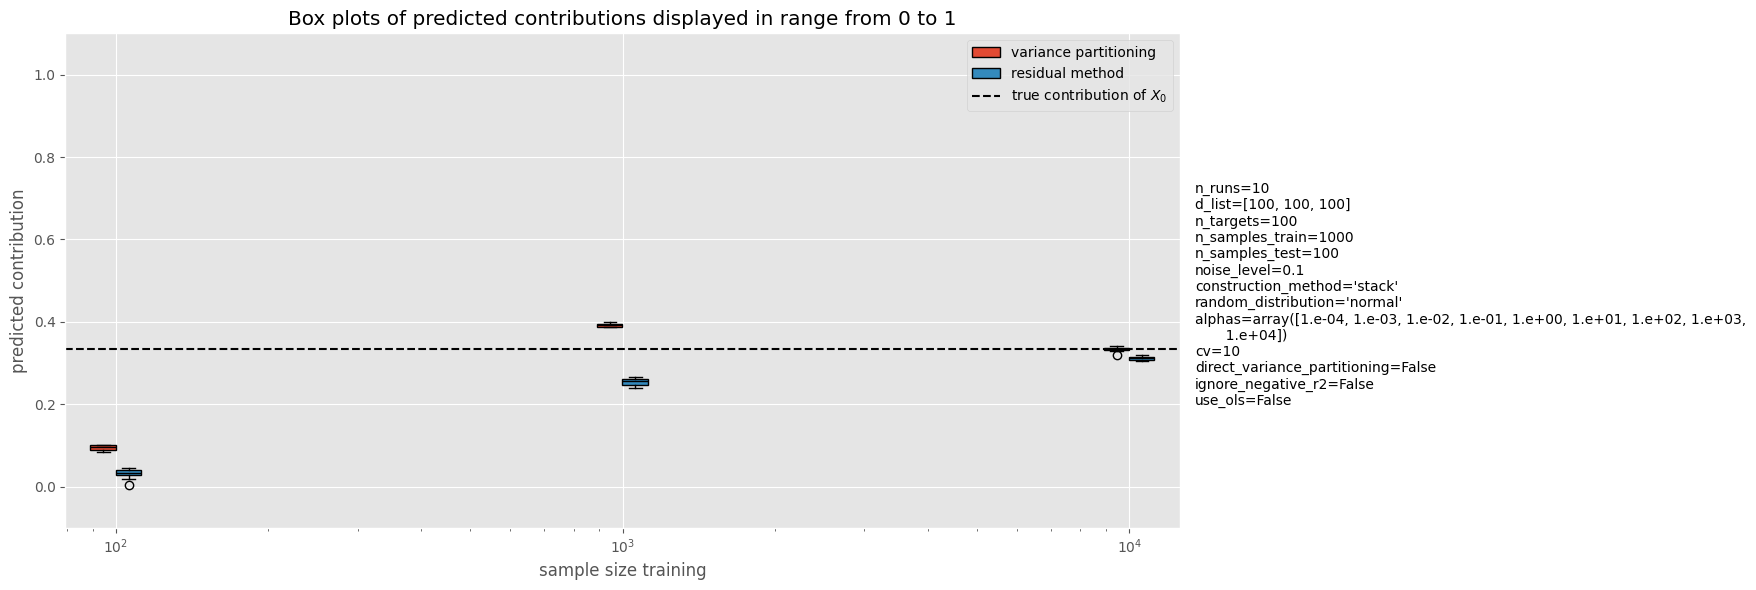

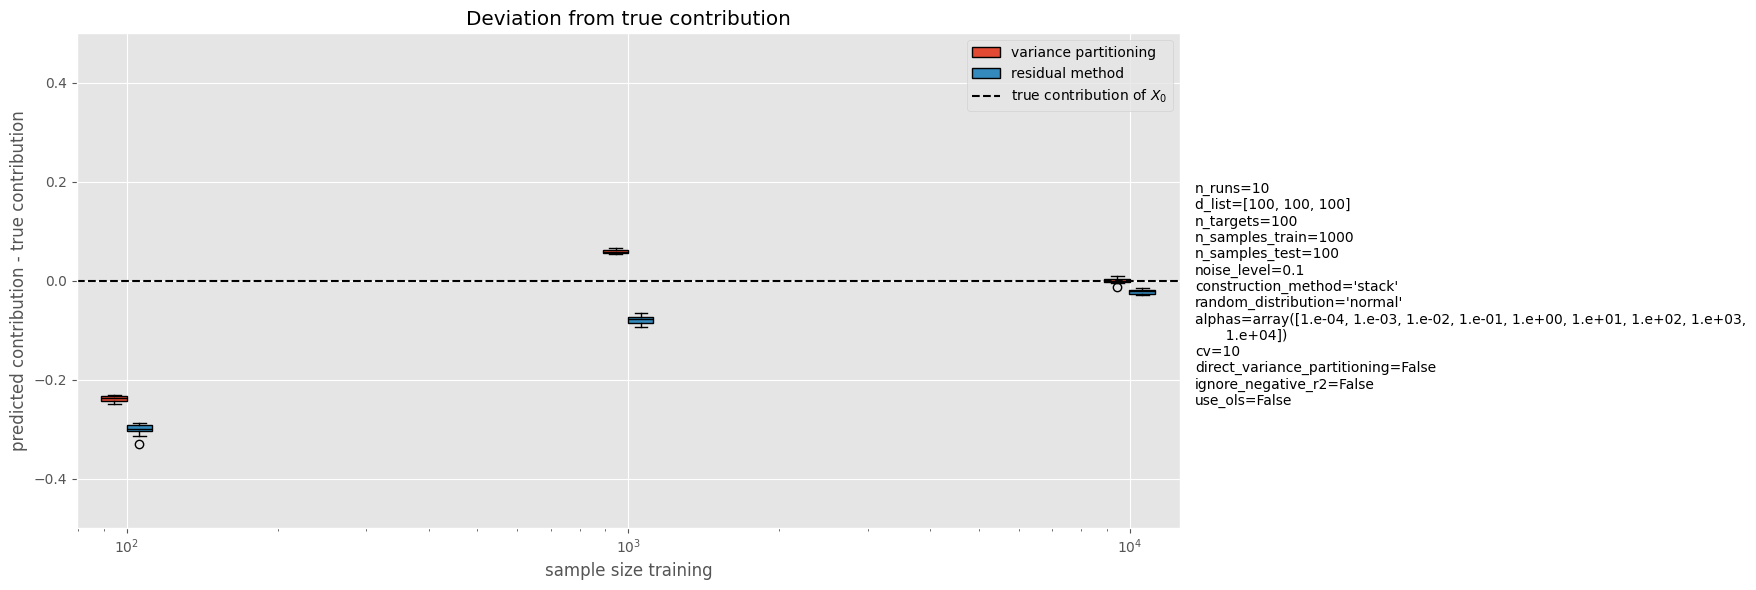

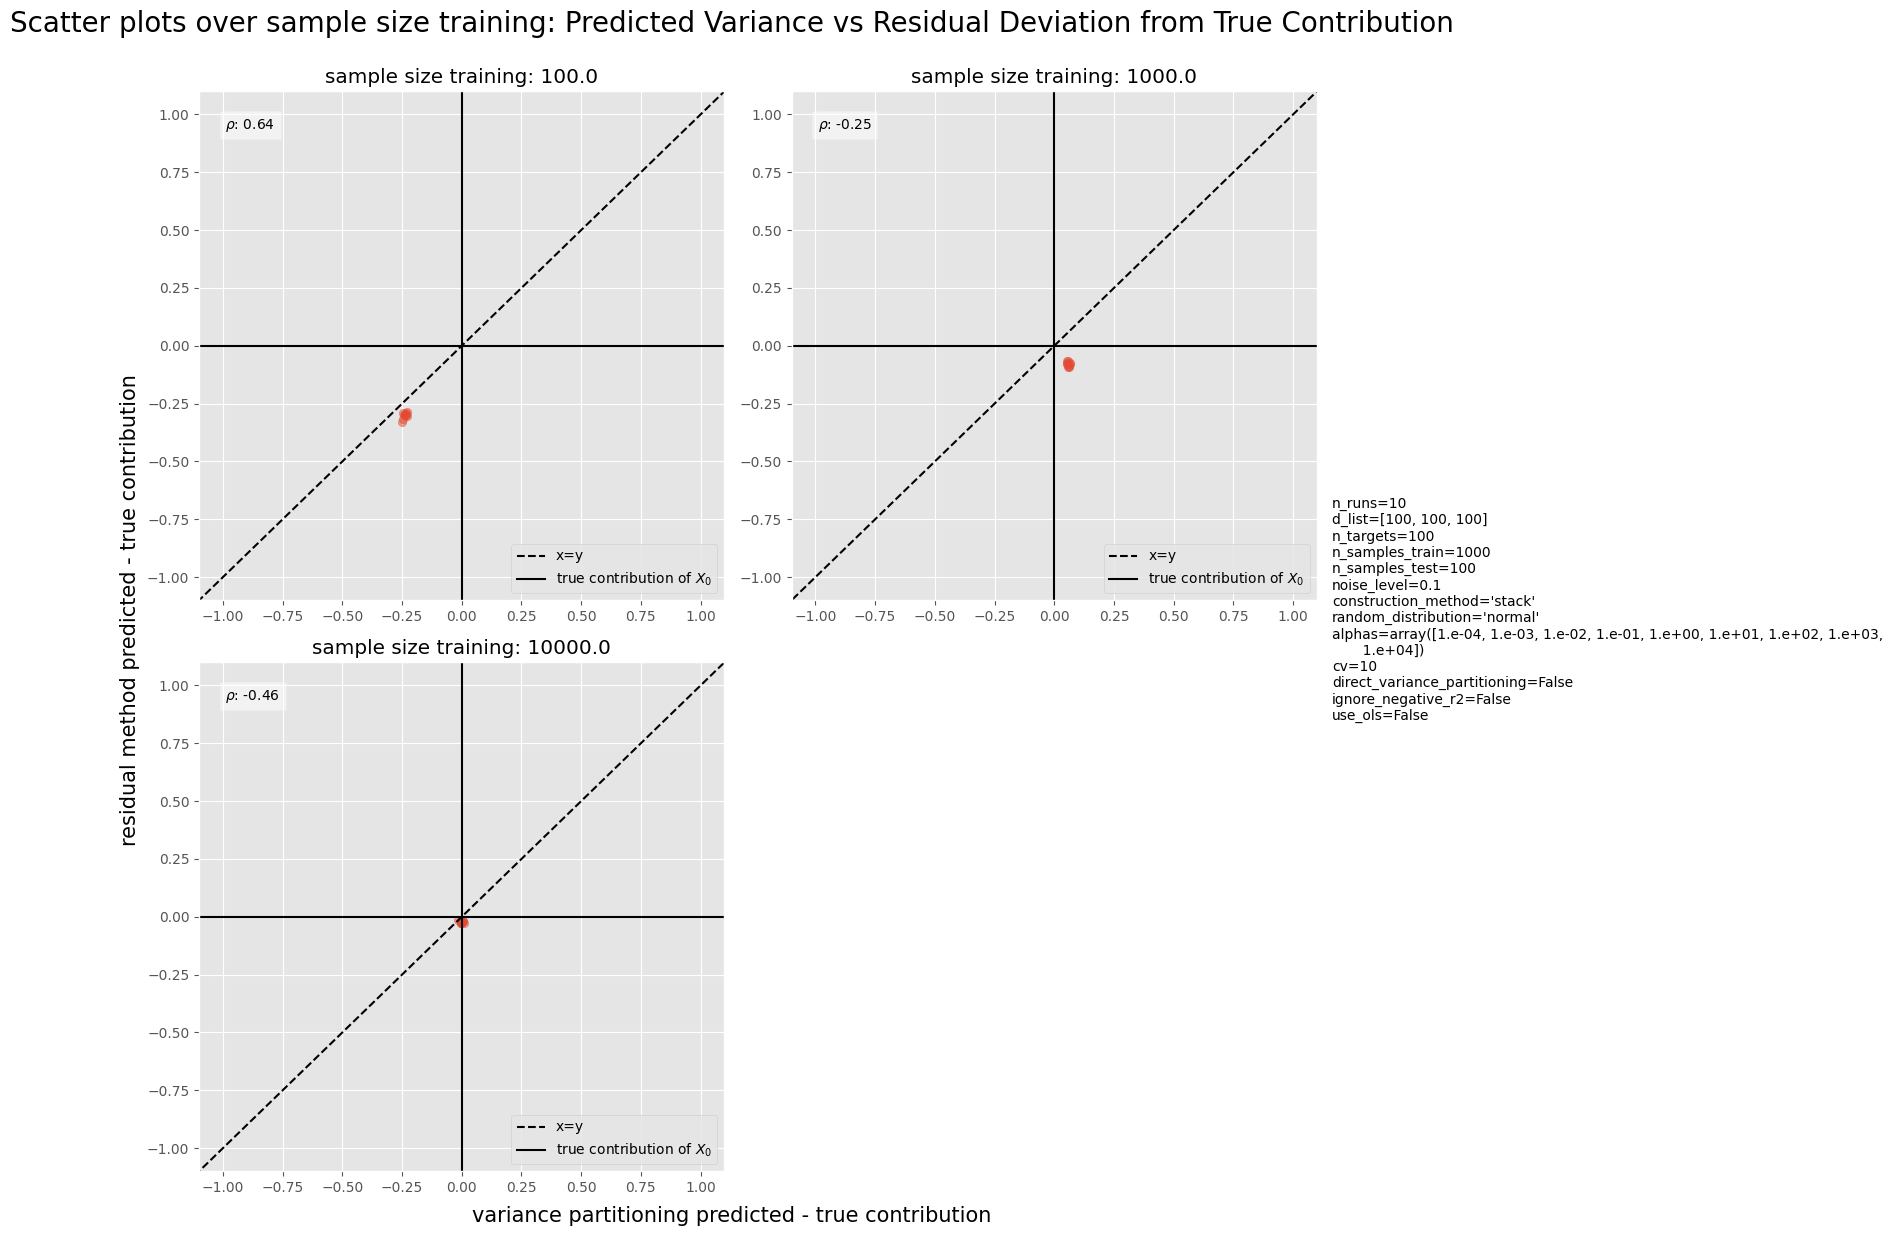

In [22]:
plot_experiment(sample_sizes_training, variable_name, predicted_variance, predicted_residual, x_is_log=True,
                **variables)

## varying test sample sizes

In [23]:
mag = np.log10(variables["n_samples_test"])
sample_sizes_testing = np.logspace(mag - 1, mag + 1, n_observations)
variable_name = "sample size testing"

In [24]:
predicted_variance, predicted_residual = run_experiment(sample_sizes_testing, variable_name, **variables)

[........................................] 100% | 99.36 sec | Varying sample size testing | 


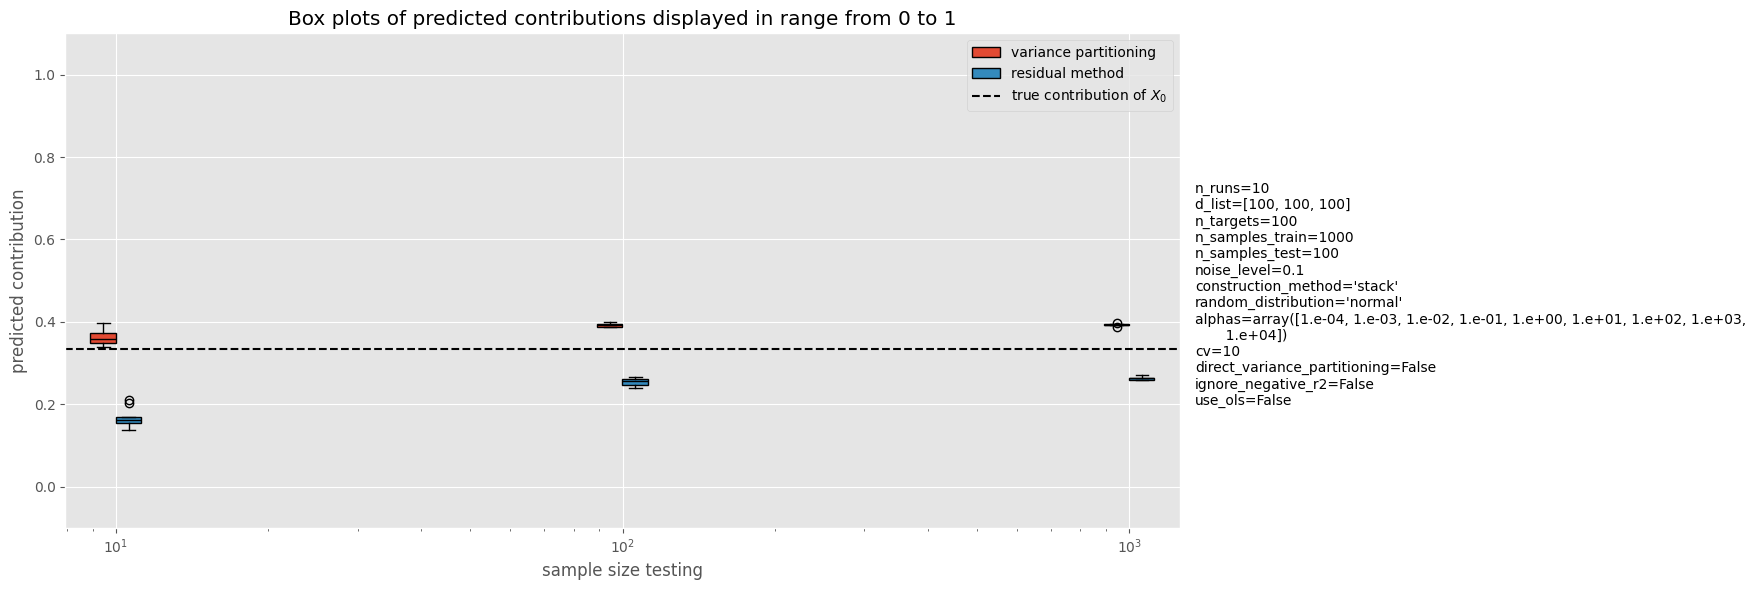

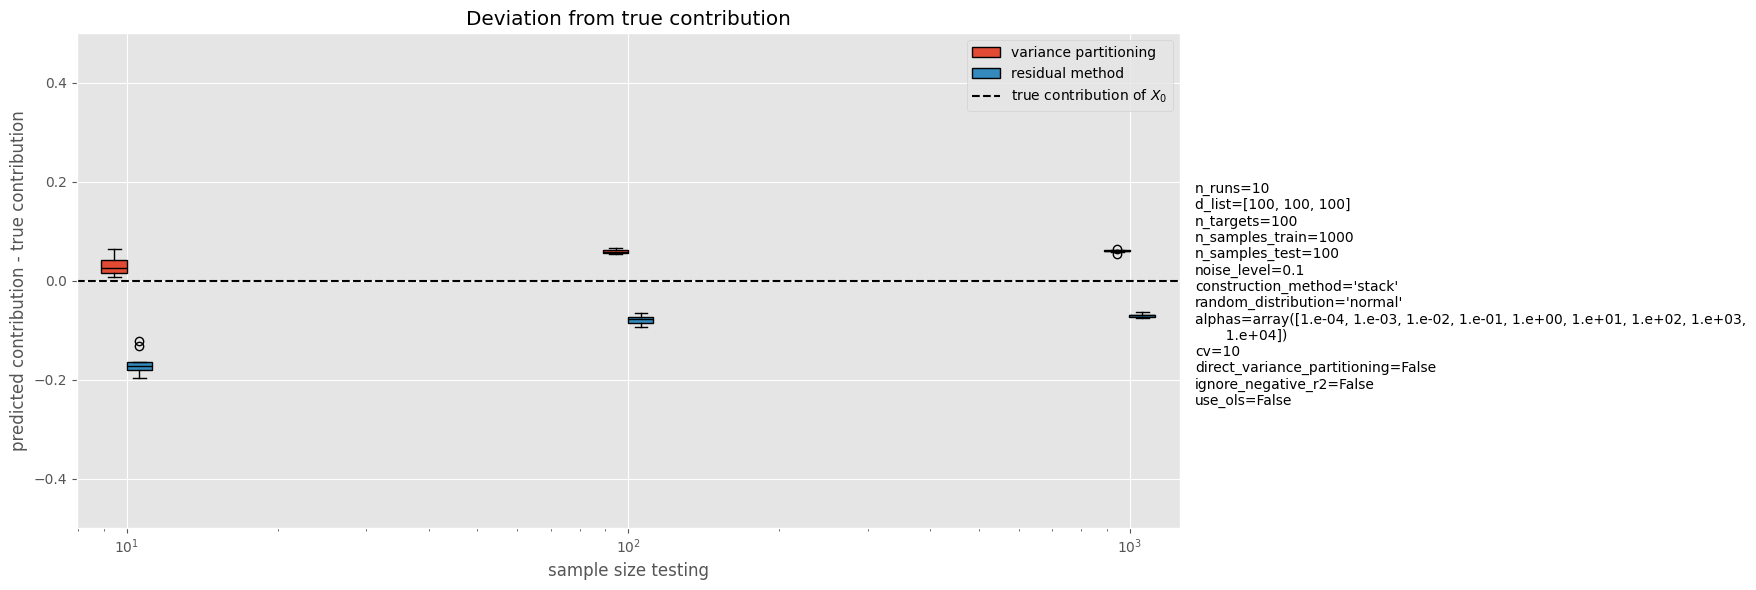

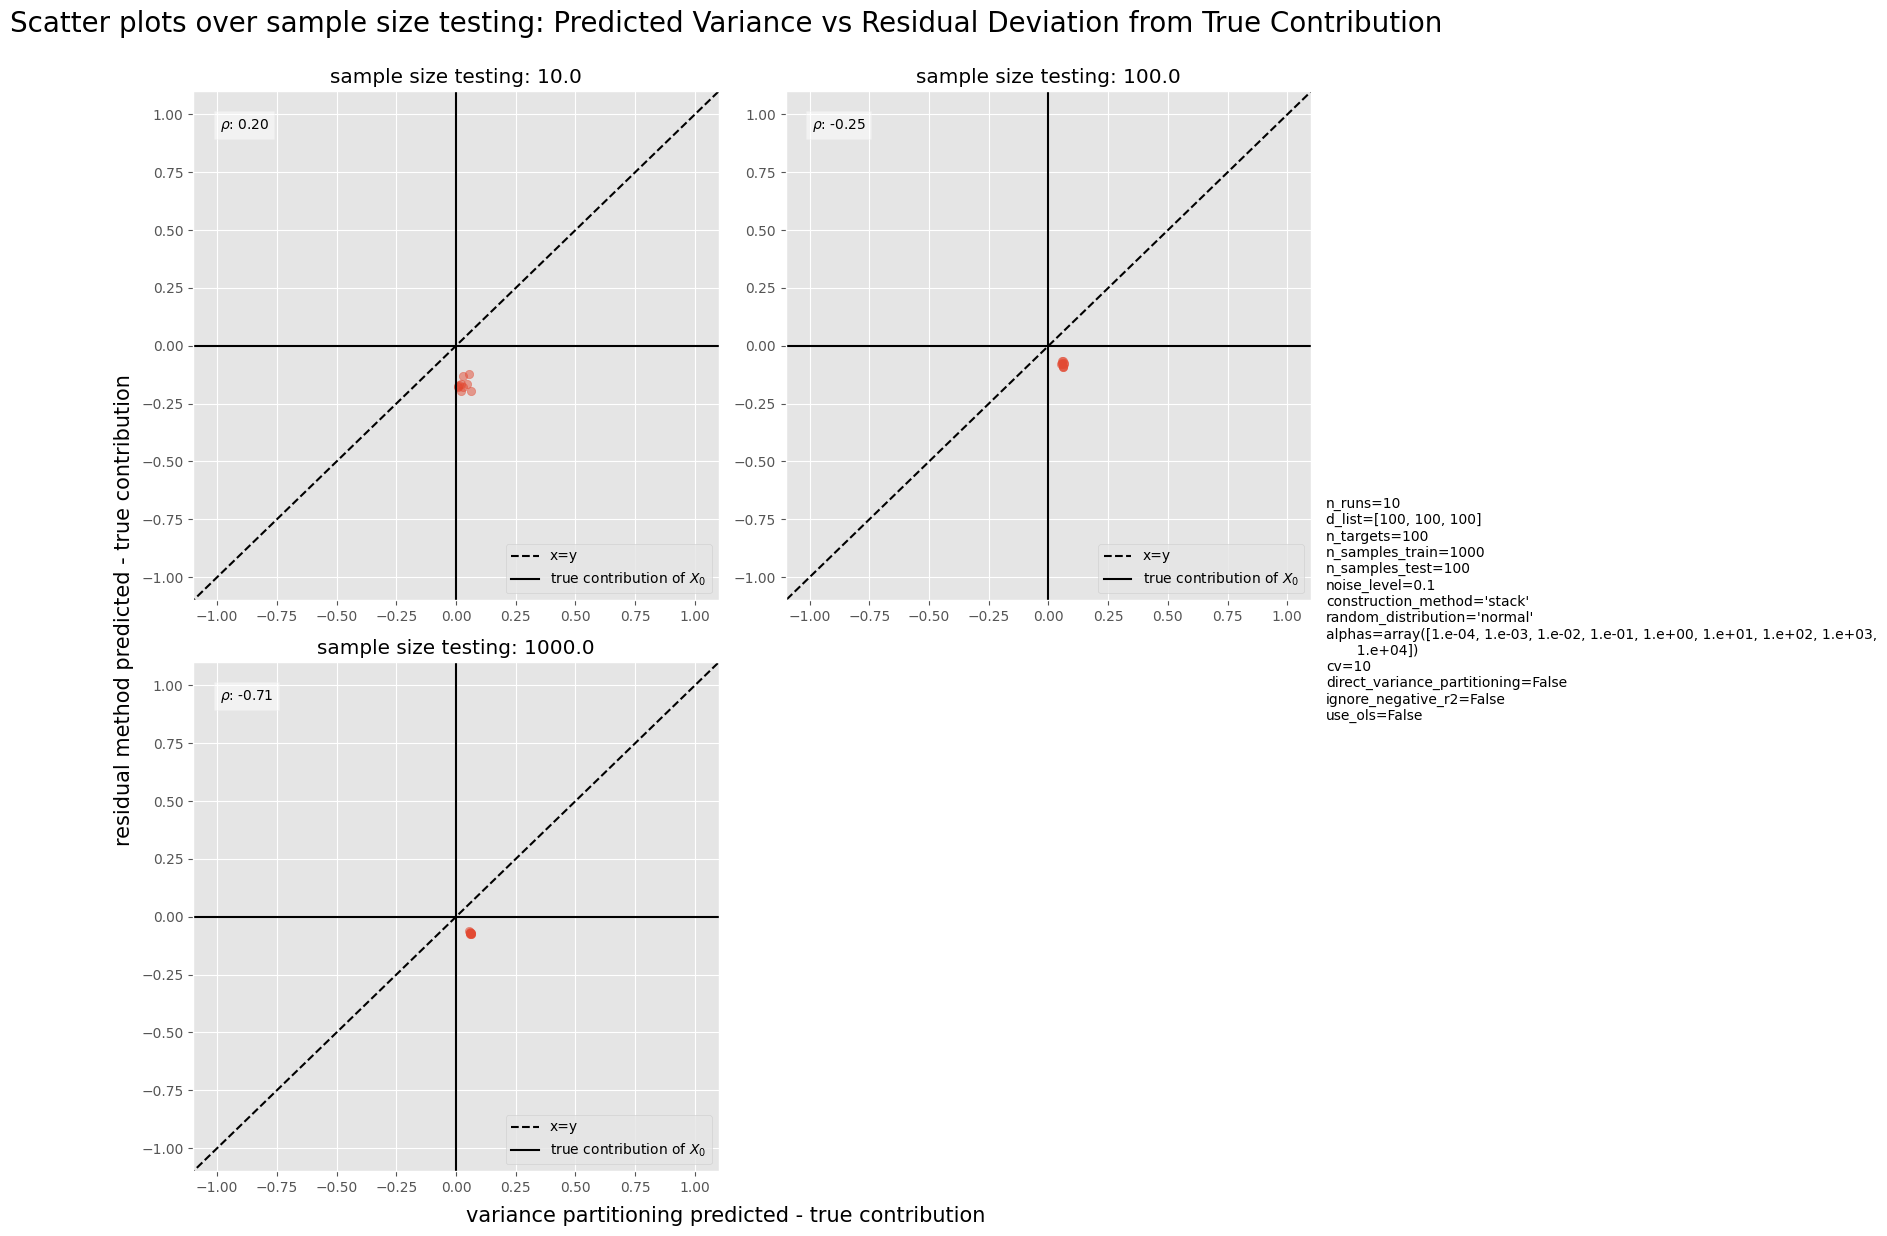

In [25]:
plot_experiment(sample_sizes_testing, variable_name, predicted_variance, predicted_residual, x_is_log=True, **variables)

# Test varying feature sizes

## only $X_0$

In [15]:
# variable_name = "number of features $X_{0}$"

In [16]:
# predicted_variance, predicted_residual = run_experiment(feature_sizes, variable_name, **variables)

In [17]:
# plot_experiment(feature_sizes, variable_name, predicted_variance, predicted_residual, x_is_log=True, **variables)

## both $X_0$ and $X_1$

In [26]:
mag = np.log10(variables["d_list"][0])
feature_sizes = np.logspace(mag - 1, mag + 1, n_observations)
variable_name = "number of features"

In [27]:
predicted_variance, predicted_residual = run_experiment(feature_sizes, variable_name, **variables)

[........................................] 100% | 263.12 sec | Varying number of features | 


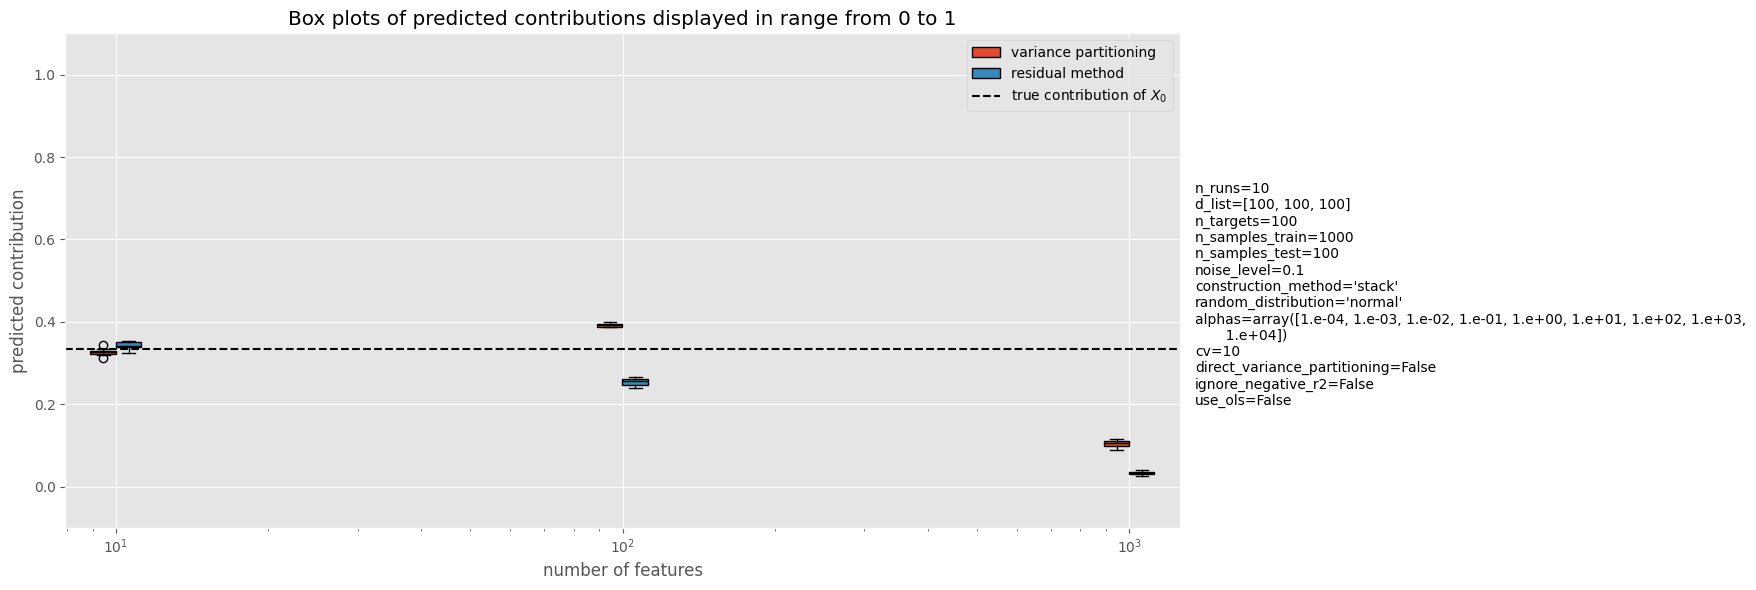

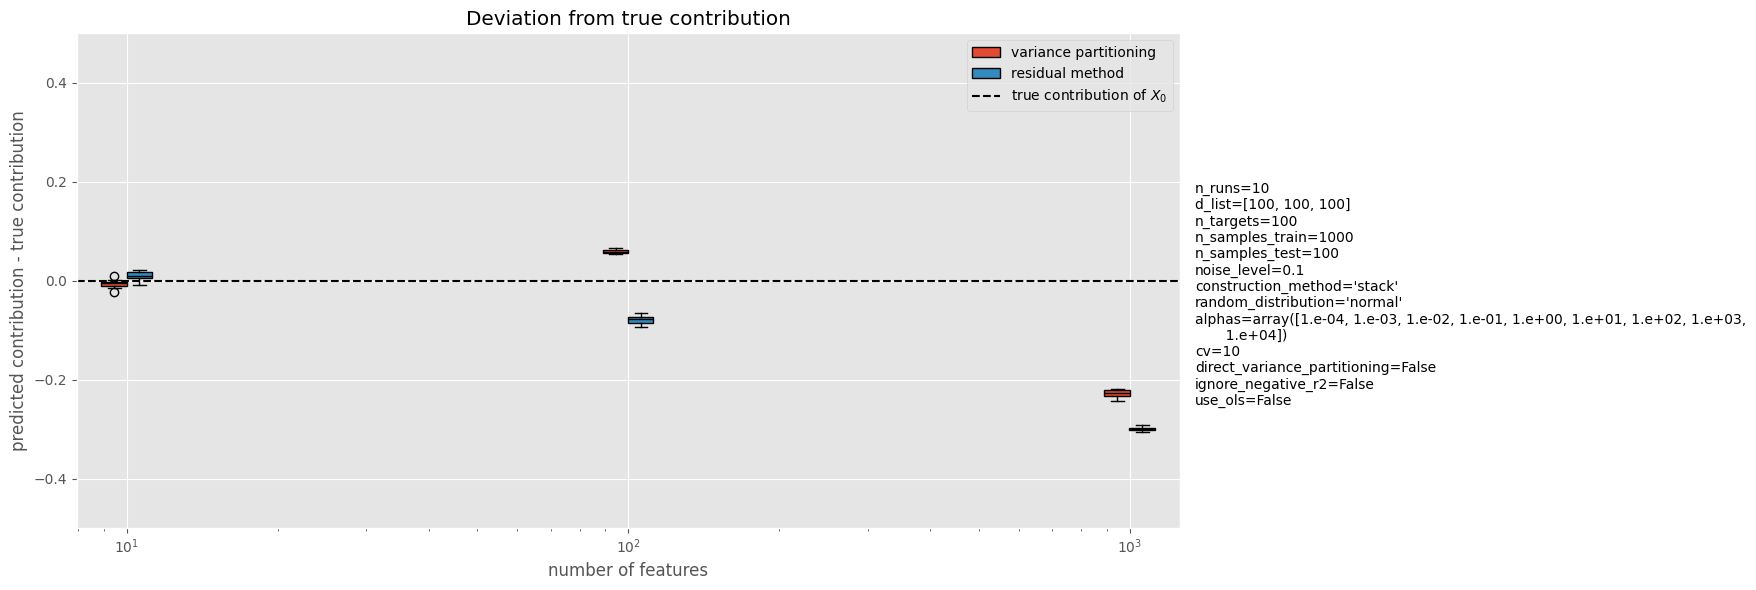

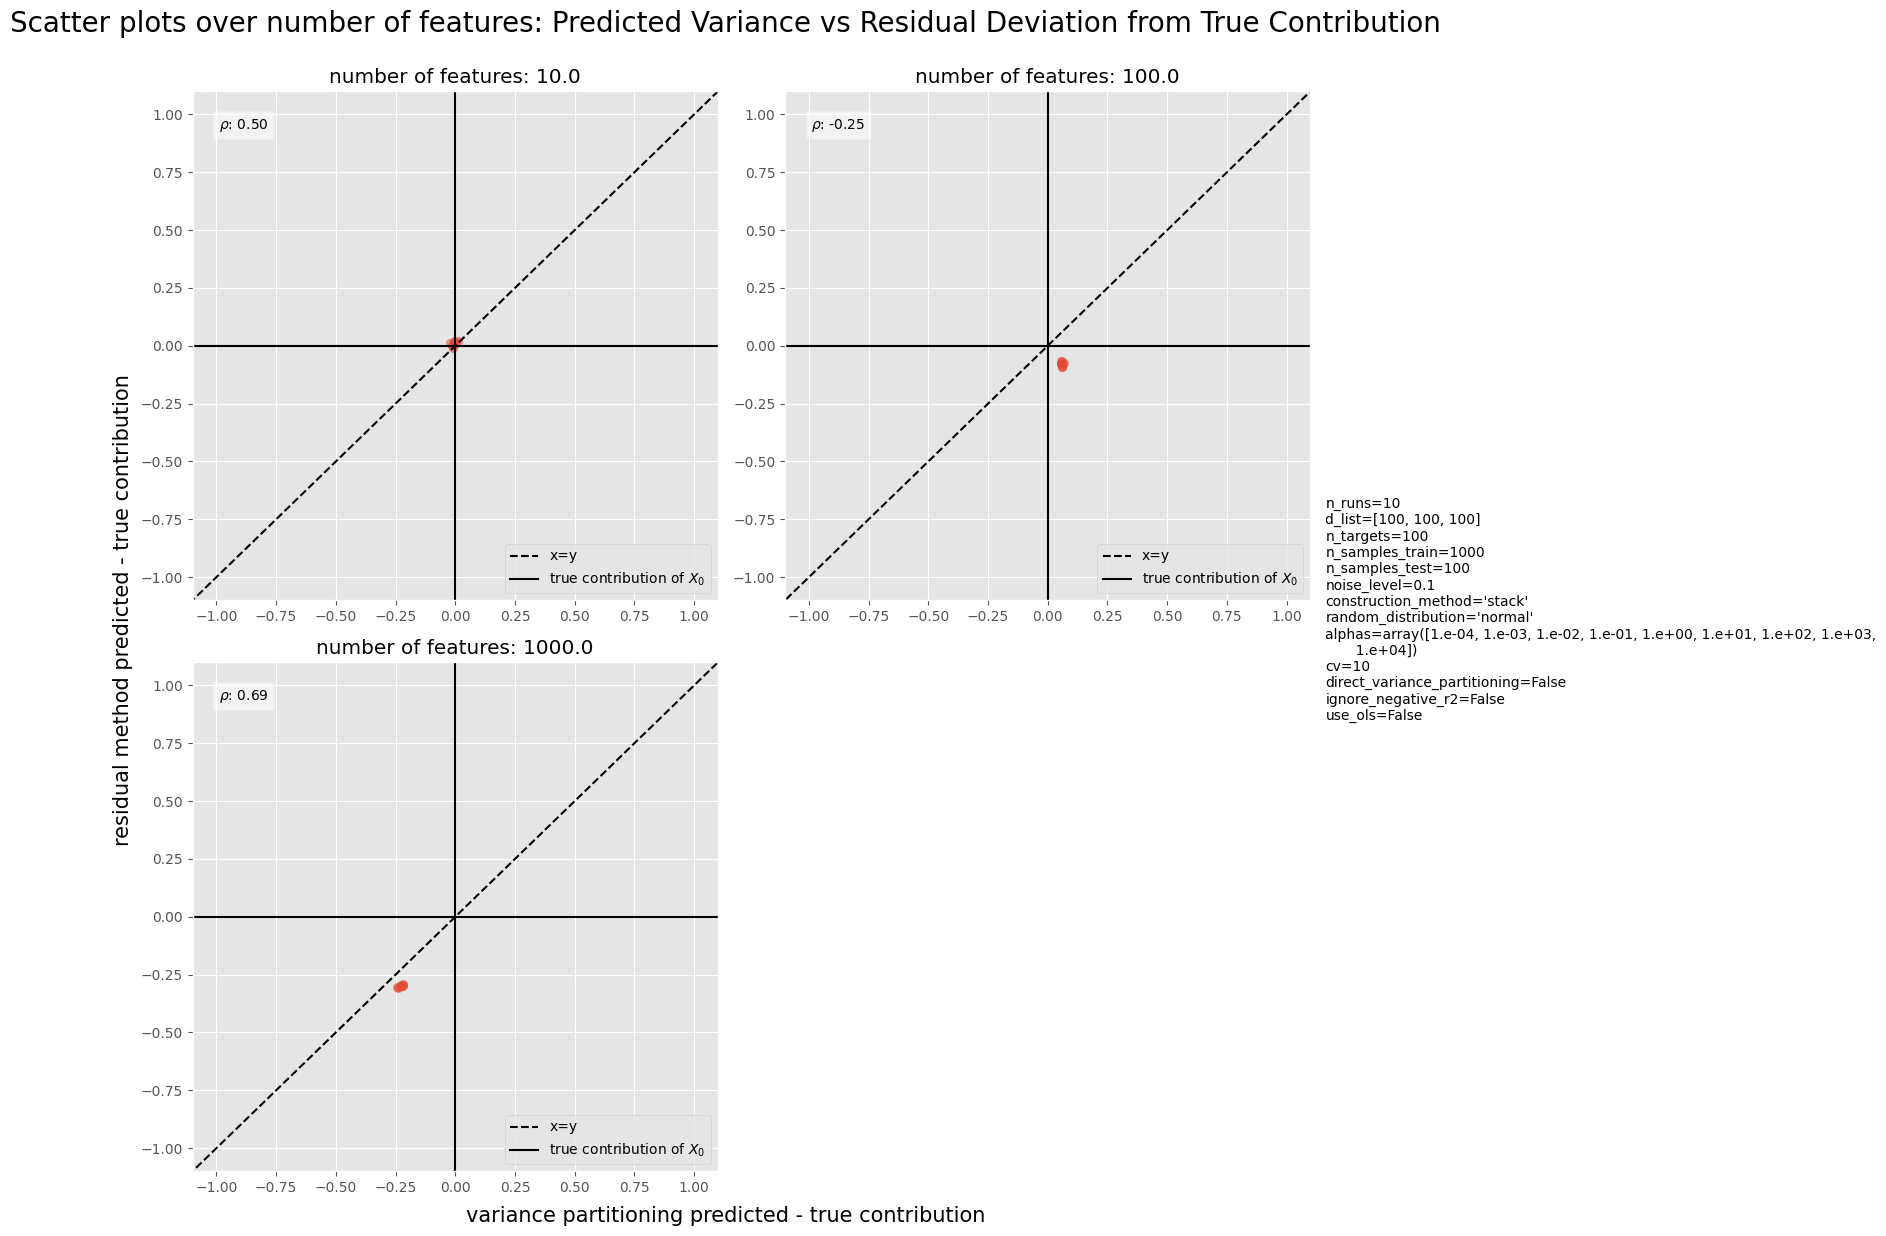

In [28]:
plot_experiment(feature_sizes, variable_name, predicted_variance, predicted_residual, x_is_log=True, **variables)

# varying target size

In [21]:
variable_name = "number of targets"
target_sizes = np.logspace(1, 3, n_observations)

In [22]:
predicted_variance, predicted_residual = run_experiment(target_sizes, variable_name, **variables)

[........................................] 100% | 20.39 sec | Varying number of targets | 


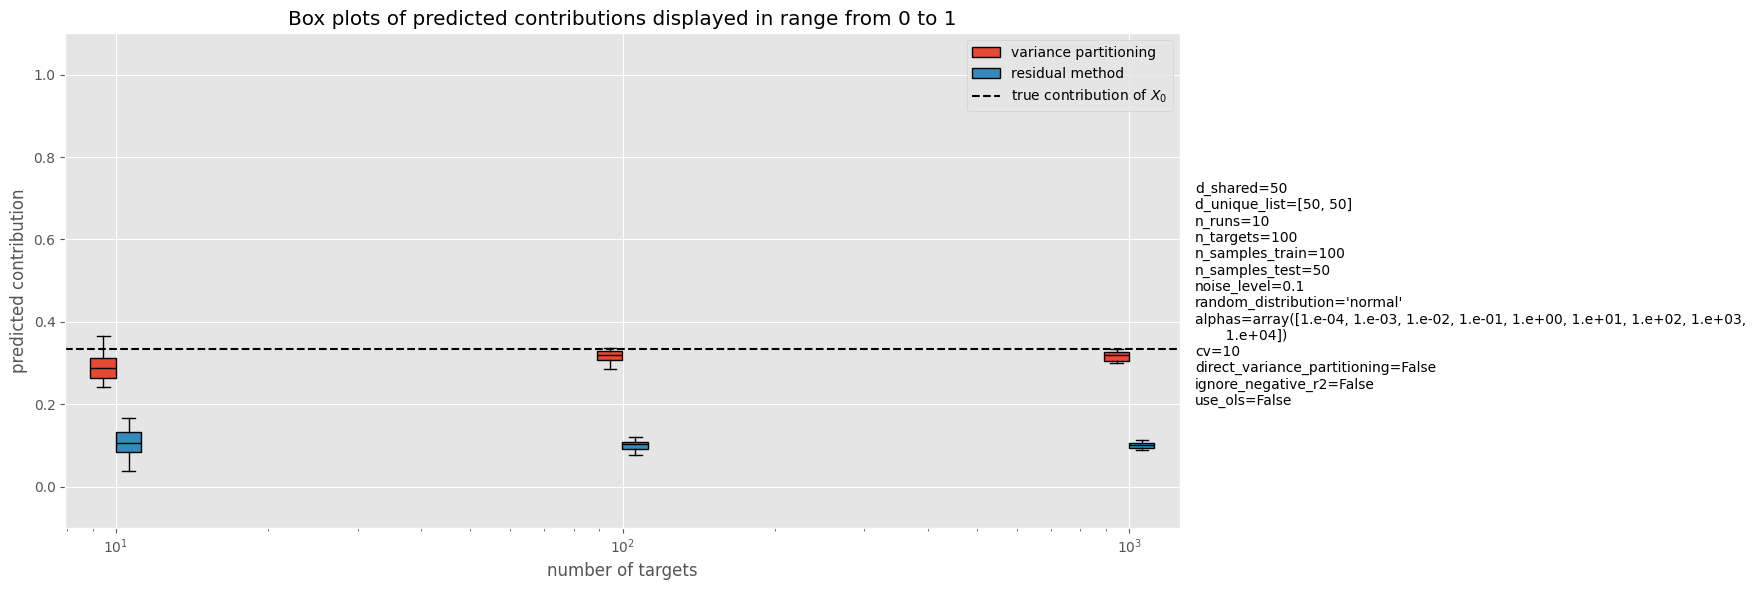

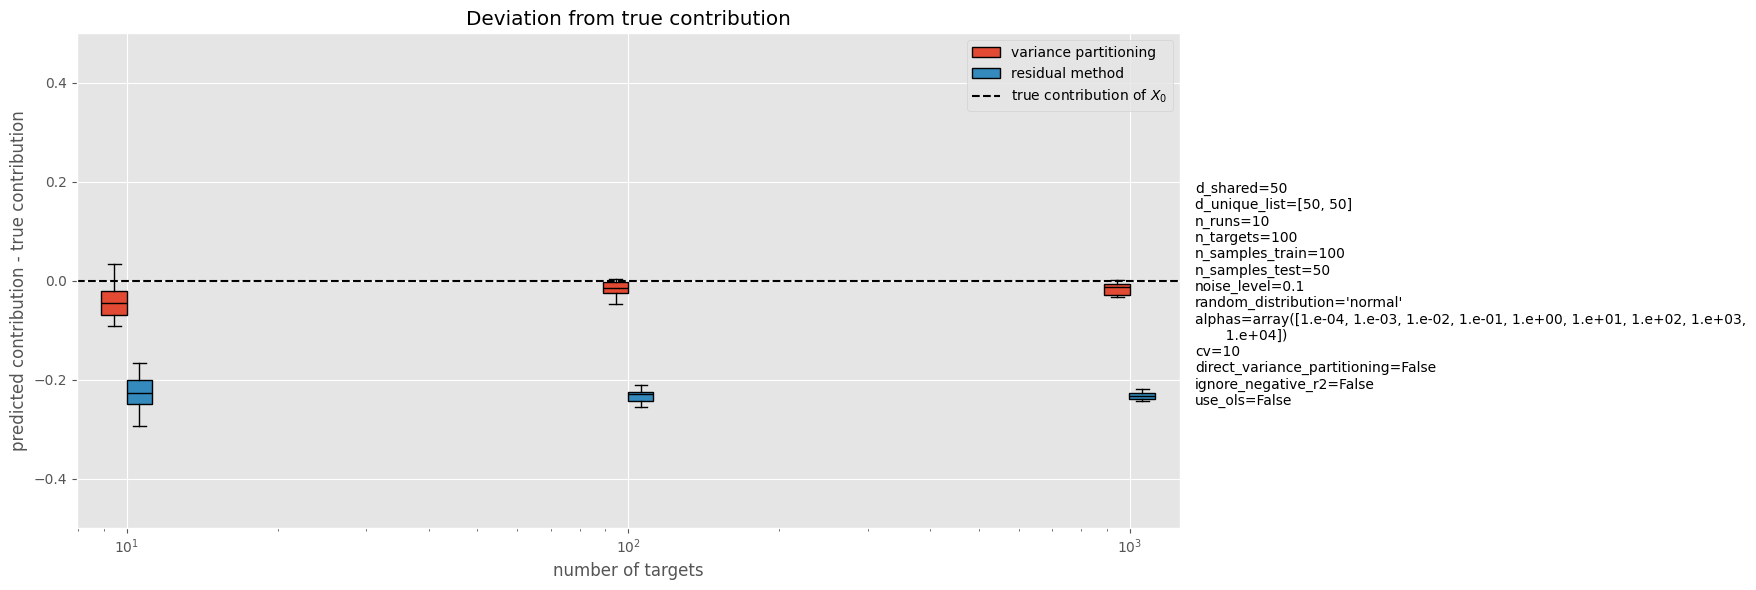

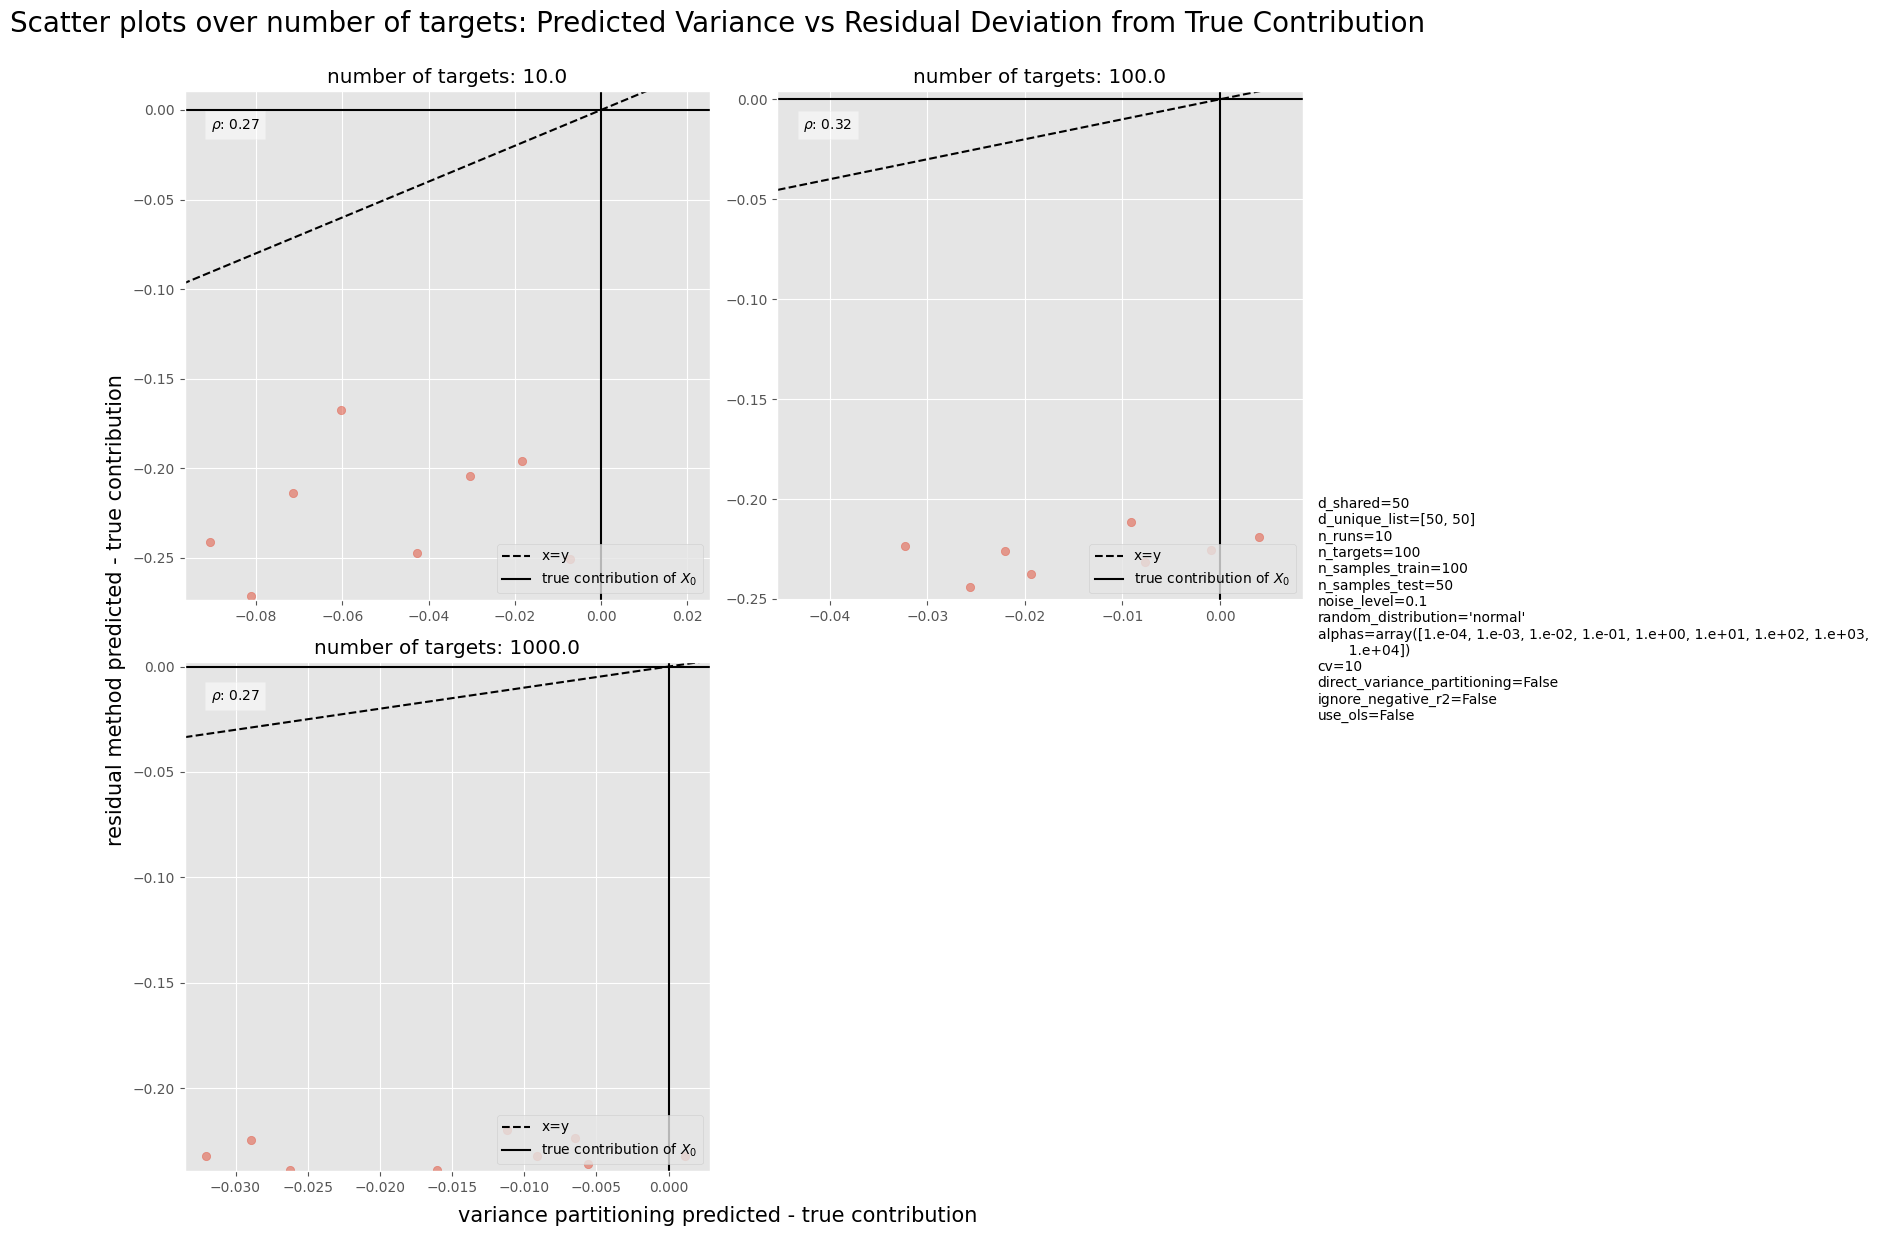

In [23]:
plot_experiment(target_sizes, variable_name, predicted_variance, predicted_residual, x_is_log=True, **variables)

# Test varying noise levels

In [29]:
variable_name = "relative amount of noise in the target"
noise_levels = np.linspace(0, 1, n_observations)

In [ ]:
predicted_variance, predicted_residual = run_experiment(noise_levels, variable_name, **variables)

[                                        ] 0% | 0.00 sec | Varying relative amount of noise in the target | 

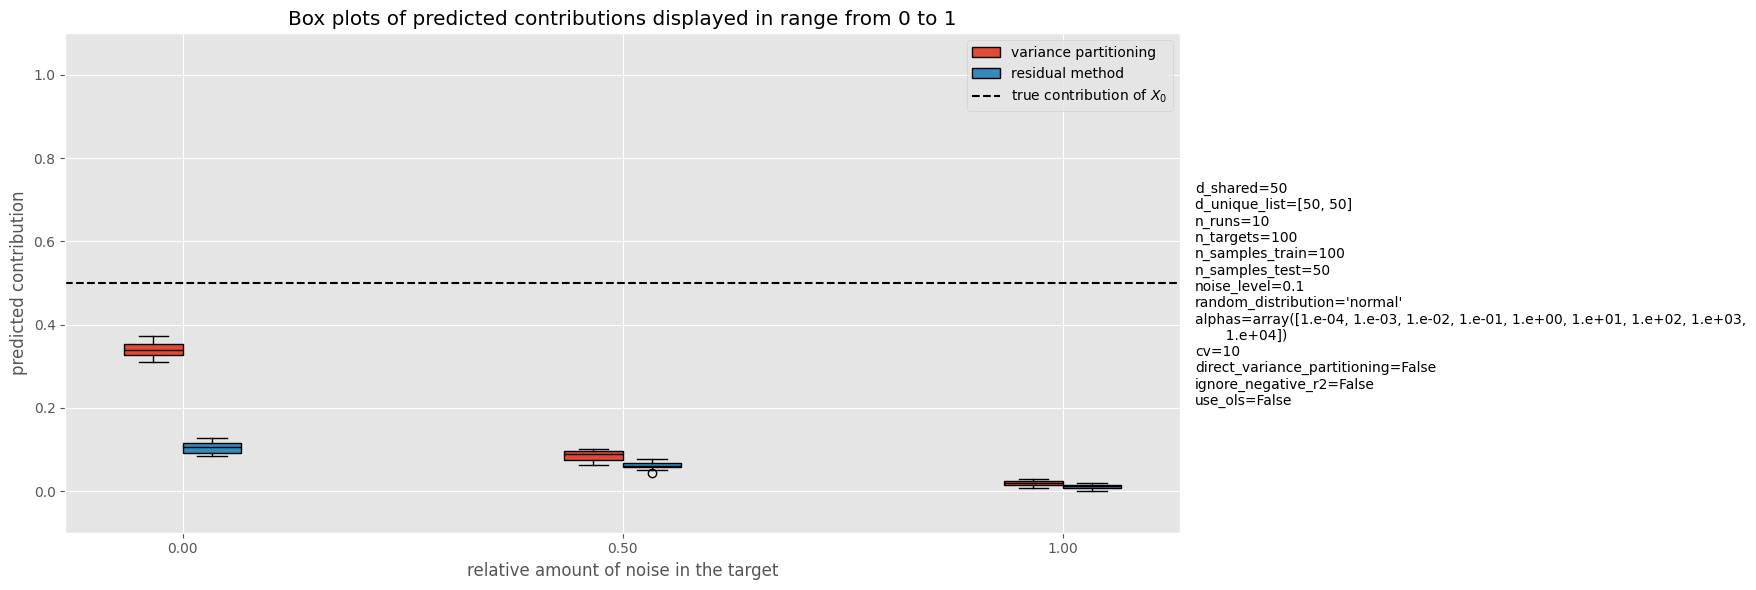

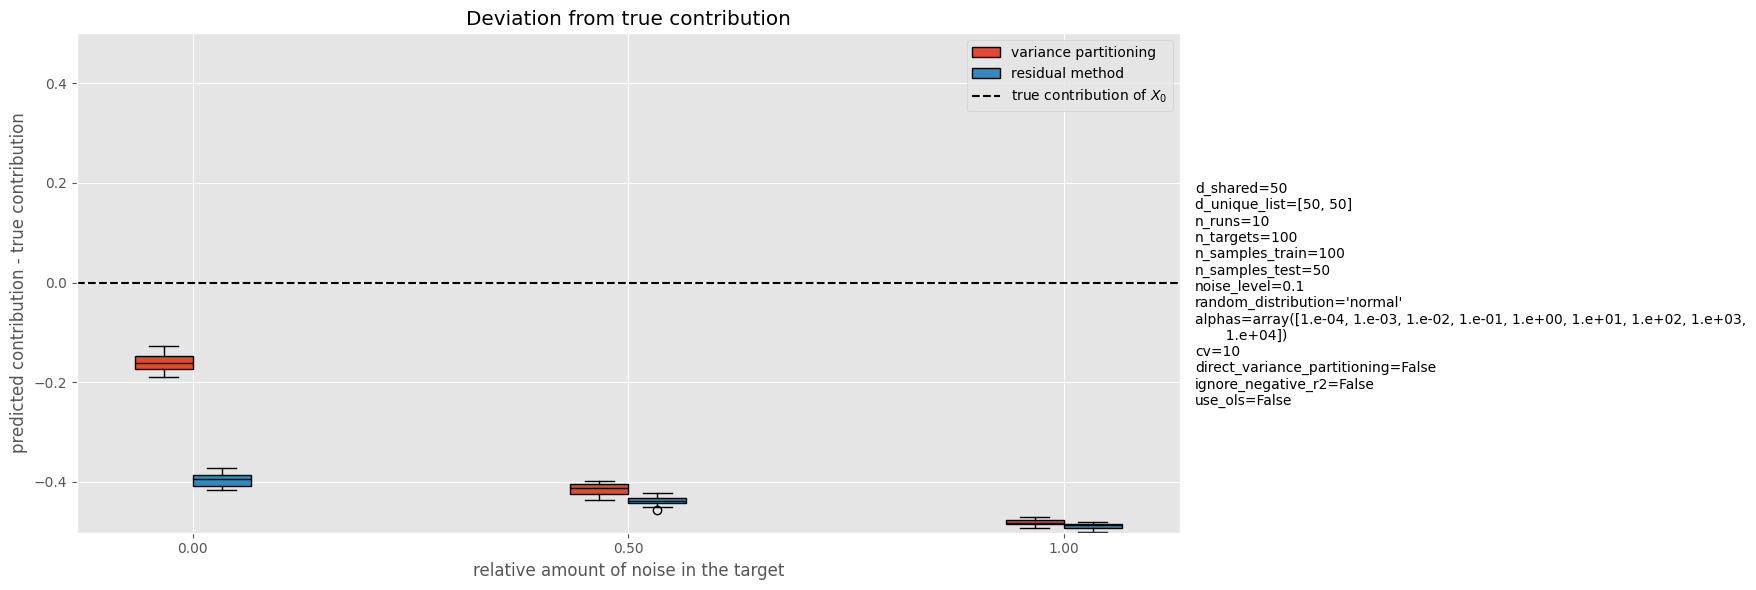

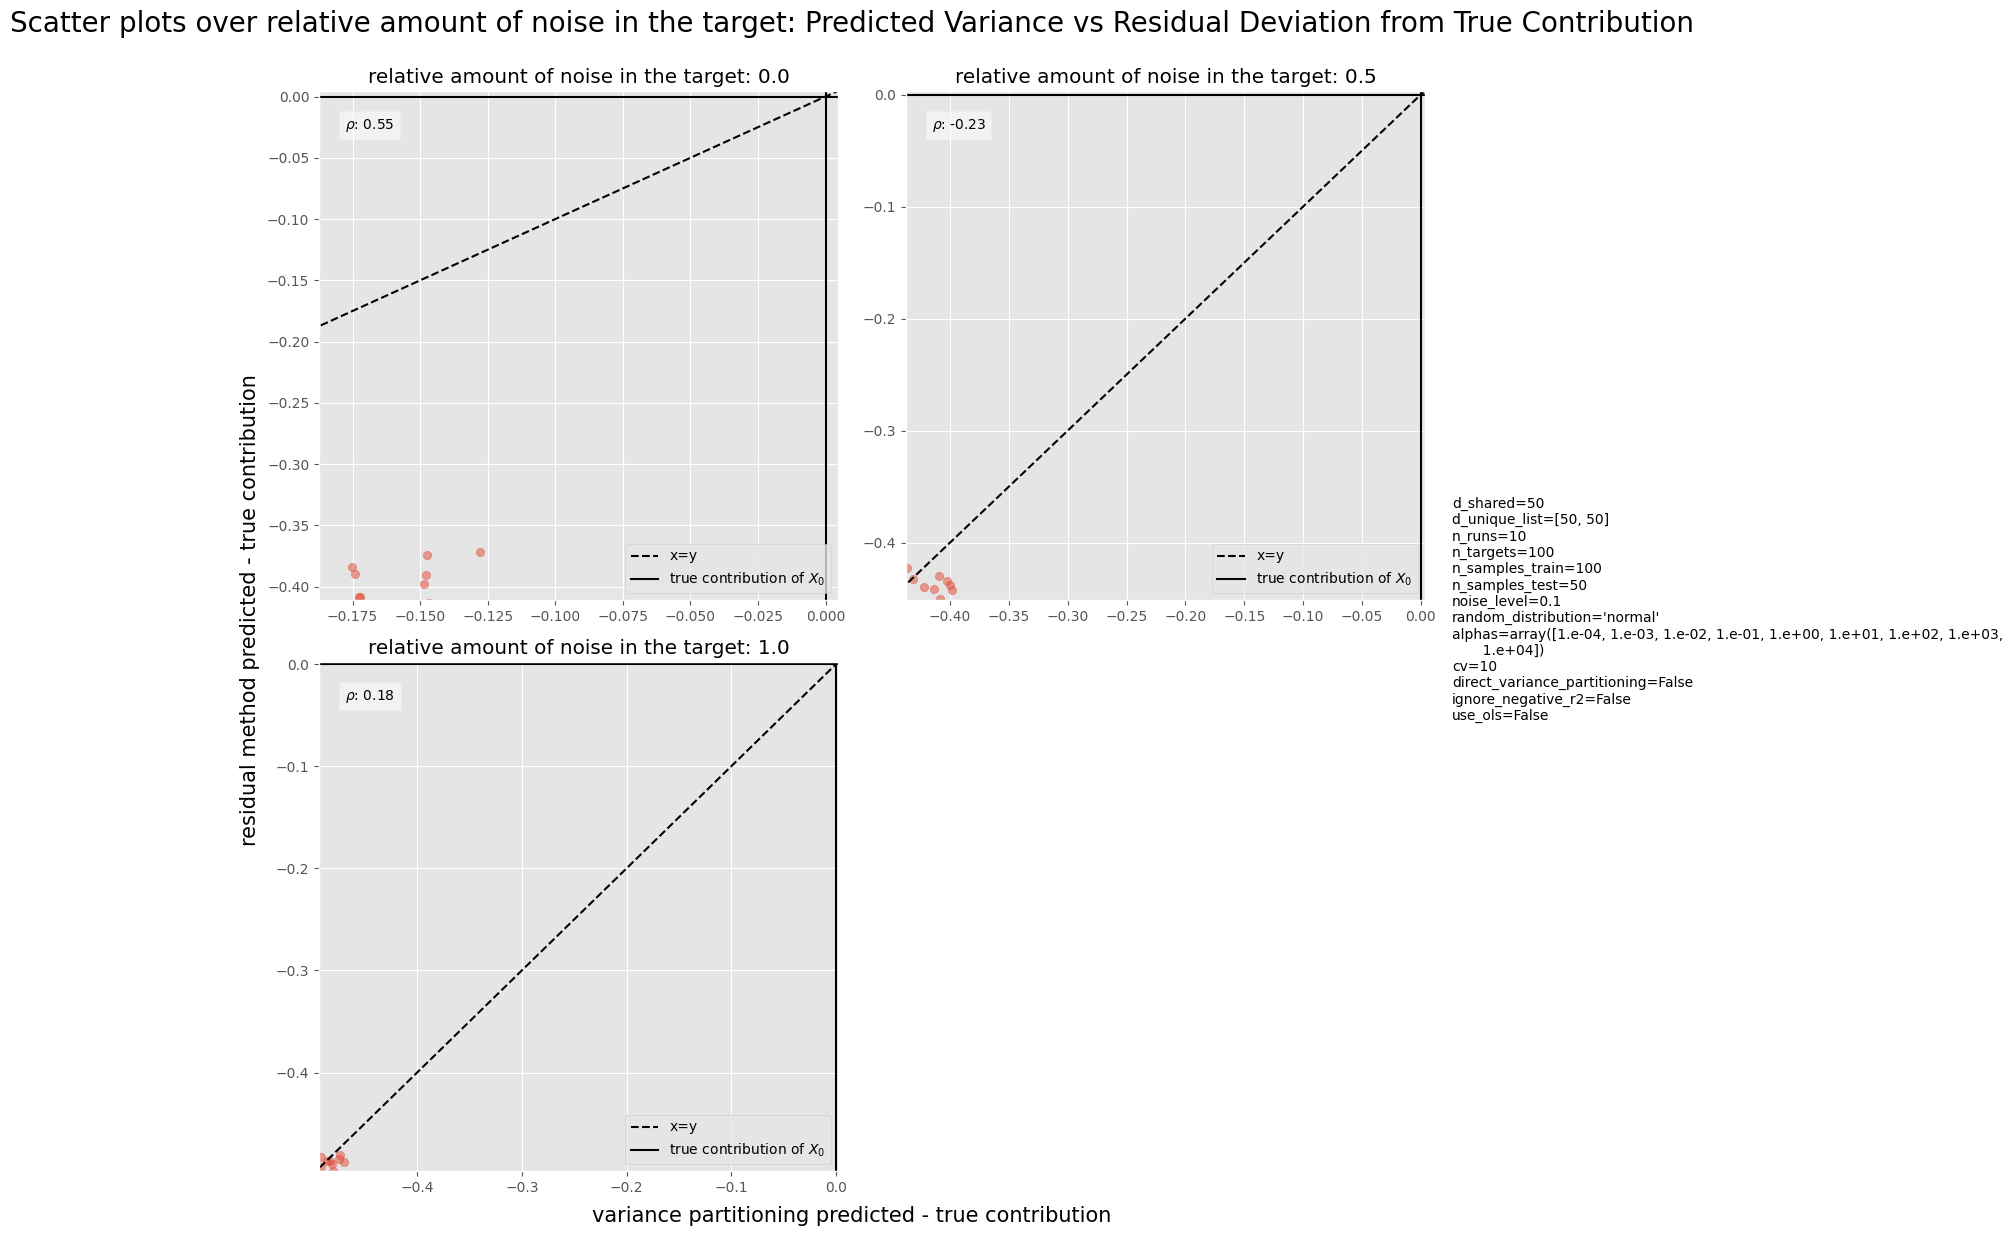

In [26]:
plot_experiment(noise_levels, variable_name, predicted_variance, predicted_residual, **variables)

# Test varying unique contributions of $X_0$ and $X_1$

In [27]:
variable_name = "proportions of unique contribution"
x0_unique_contributions = np.linspace(0, 1, n_observations)
# convert from np to python
x0_unique_contributions = [round(float(x), 2) for x in x0_unique_contributions]

In [28]:
# for x0_unique_contribution in x0_unique_contributions:
#     contributions = [[x0_unique_contribution, round((1 - x0_unique_contribution) * x1 / (n_observations - 1), 2)] for
#                      x1 in range(n_observations)]
#     predicted_variance, predicted_residual = run_experiment(contributions, variable_name, **variables)
#     variables_without_unique_contributions = variables.copy()
#     variables_without_unique_contributions.__delitem__("unique_contributions")
#     plot_experiment(contributions, variable_name, predicted_variance, predicted_residual, unique_contributions=[x0_unique_contribution, "varying"], **variables_without_unique_contributions)